In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
# Parameters
sample_rate = 1000  # Hz
duration = 1000  # seconds
time = np.arange(0, duration, 1/sample_rate)

# Shared low-frequency modulation signal (smooth amplitude changes)
shared_modulation_frequency = 0.1  # Hz
shared_modulation = 1 + 0.5 * np.sin(2 * np.pi * shared_modulation_frequency * time)

# Inverted modulation signal for theta and gamma
inverted_modulation = 1 - 0.5 * np.sin(2 * np.pi * shared_modulation_frequency * time)

# Function to create unique mid-frequency modulation for each band
def create_mid_frequency_modulation(frequency, amplitude, time):
    return 1 + amplitude * np.sin(2 * np.pi * frequency * time)

# Function to scale amplitude with inverse power law
def scale_amplitude(frequency, signal):
    return signal / np.sqrt(frequency) # softer effect

# Frequency bands with amplitude modulation (scaled with inverse power law)
slow_wave = scale_amplitude(0.5, np.sin(2 * np.pi * 0.5 * time)) * shared_modulation
delta_wave = scale_amplitude(2, np.sin(2 * np.pi * 2 * time)) * shared_modulation * create_mid_frequency_modulation(0.2, 0.3, time)
theta_wave = scale_amplitude(6, np.sin(2 * np.pi * 6 * time)) * inverted_modulation * create_mid_frequency_modulation(0.3, 0.3, time)
alpha_wave = scale_amplitude(10, np.sin(2 * np.pi * 10 * time)) * shared_modulation * create_mid_frequency_modulation(0.4, 0.3, time)
beta_wave = scale_amplitude(20, np.sin(2 * np.pi * 20 * time)) * shared_modulation * create_mid_frequency_modulation(0.5, 0.3, time)
gamma_wave = scale_amplitude(40, np.sin(2 * np.pi * 40 * time)) * inverted_modulation * theta_wave

# Parameters to control frequency of SWRs and IEDs
swr_frequency_param = 1.5  # Lower value -> more frequent SWRs
ied_frequency_param = 2.5  # Lower value -> more frequent IEDs

# Sharp Wave Ripples (SWRs) - Controlled intervals
swr = np.zeros_like(time)
swr_duration = 0.10  # 50ms
t = 0
while t < duration:
    t += np.random.uniform(0, swr_frequency_param)
    start_idx = int(t * sample_rate)
    end_idx = int(start_idx + swr_duration * sample_rate)
    swr[start_idx:end_idx] = np.sin(2 * np.pi * 100 * time[start_idx:end_idx])

# Function to create a sigmoid transition for IED
def sigmoid_transition(x):
    return 2 / (1 + np.exp(-10 * x)) - 1

# Function to create a sharp negative Gaussian spike
def negative_gaussian_spike(x, amplitude, duration):
    return -amplitude * np.exp(-((x - 0.5 * duration)**2) / (2 * (0.005**2)))

# Interictal Epileptiform Discharges (IEDs) with initial negative spike followed by broad positive wave
ied = np.zeros_like(time)
ied_amplitude = 5
ied_duration = 0.1  # 100ms (broader)
ied_spike_duration = 0.02  # 20ms for the initial spike
t = 0
while t < duration:
    t += np.random.uniform(0, ied_frequency_param)
    start_idx = int(t * sample_rate)
    spike_end_idx = int(start_idx + ied_spike_duration * sample_rate)
    end_idx = int(start_idx + ied_duration * sample_rate)

    # Create initial negative spike
    ied_time_spike = time[start_idx:spike_end_idx] - t
    ied[start_idx:spike_end_idx] = negative_gaussian_spike(ied_time_spike, ied_amplitude, ied_spike_duration)

    # Create broad positive wave with sigmoid transition
    ied_time_wave = (time[spike_end_idx:end_idx] - (t + ied_spike_duration)) / (ied_duration - ied_spike_duration)
    ied[spike_end_idx:end_idx] = ied_amplitude * sigmoid_transition(ied_time_wave)

# Composite signal
composite_signal = slow_wave + delta_wave + theta_wave + alpha_wave + beta_wave + gamma_wave + swr + ied

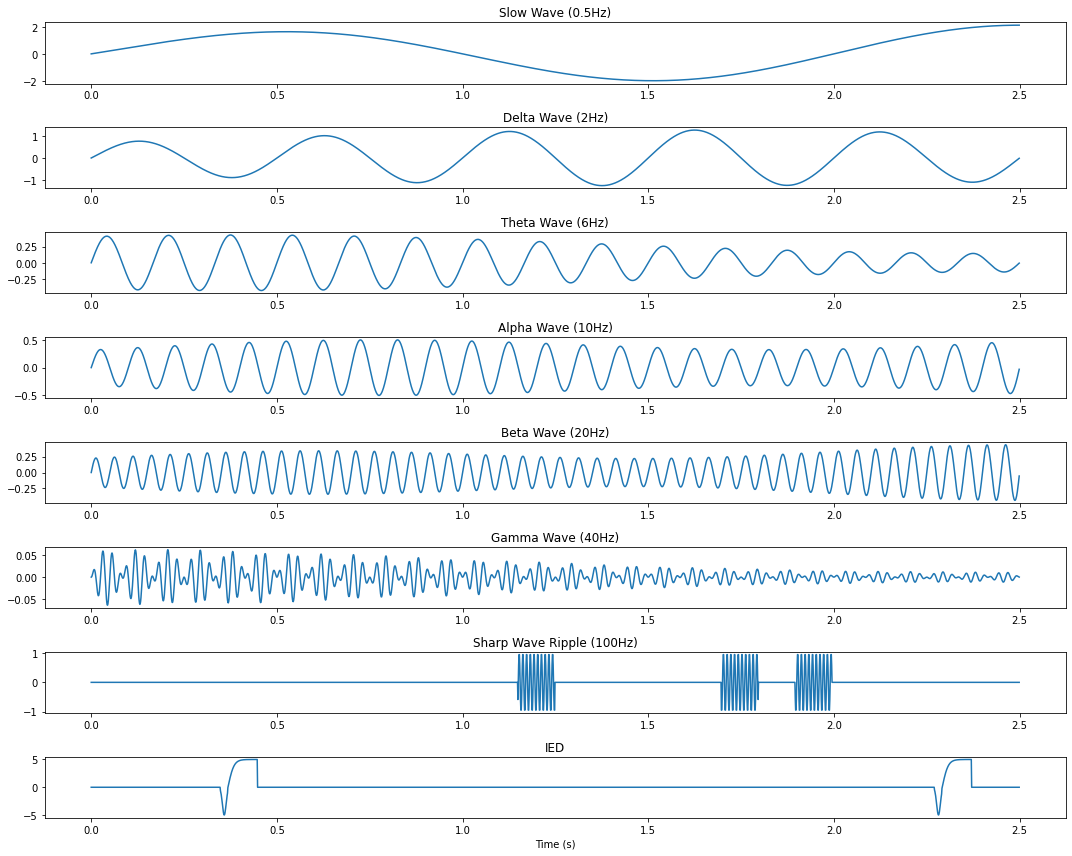

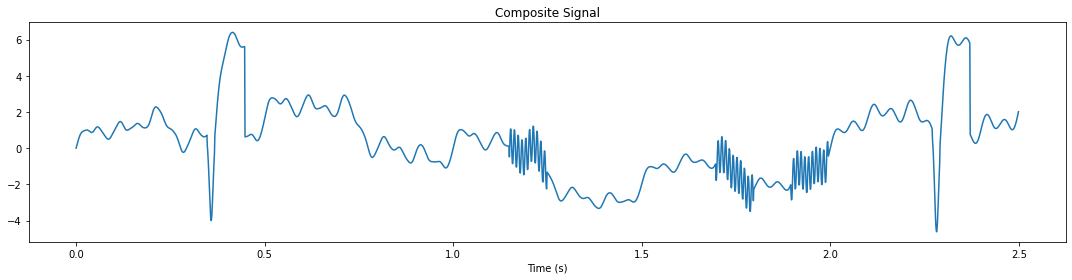

In [35]:
# Plot the signals
plt.figure(figsize=(15, 12))

plt.subplot(8, 1, 1)
plt.plot(time[:2500], slow_wave[:2500])
plt.title('Slow Wave (0.5Hz)')

plt.subplot(8, 1, 2)
plt.plot(time[:2500], delta_wave[:2500])
plt.title('Delta Wave (2Hz)')

plt.subplot(8, 1, 3)
plt.plot(time[:2500], theta_wave[:2500])
plt.title('Theta Wave (6Hz)')

plt.subplot(8, 1, 4)
plt.plot(time[:2500], alpha_wave[:2500])
plt.title('Alpha Wave (10Hz)')

plt.subplot(8, 1, 5)
plt.plot(time[:2500], beta_wave[:2500])
plt.title('Beta Wave (20Hz)')

plt.subplot(8, 1, 6)
plt.plot(time[:2500], gamma_wave[:2500])
plt.title('Gamma Wave (40Hz)')

plt.subplot(8, 1, 7)
plt.plot(time[:2500], swr[:2500])
plt.title('Sharp Wave Ripple (100Hz)')

plt.subplot(8, 1, 8)
plt.plot(time[:2500], ied[:2500])
plt.title('IED')

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Plot the composite signal
plt.figure(figsize=(15, 4))
plt.plot(time[:2500], composite_signal[:2500])

plt.title('Composite Signal')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

In [23]:
# Create a DataFrame
data = {
    'slow_wave': slow_wave,
    'delta_wave': delta_wave,
    'theta_wave': theta_wave,
    'alpha_wave': alpha_wave,
    'beta_wave': beta_wave,
    'gamma_wave': gamma_wave,
    'swr': swr,
    'ied': ied,
    'composite_signal': composite_signal
}

df = pd.DataFrame(data)

# Write to CSV
df.to_csv('signals.csv', index=False)